# BPI Challenge 2018

In [6]:
import pandas as pd
from datetime import datetime

## Understanding the problem of undesidered outcomes

A case is opened usually in May and should be closed by end of the year.

When this doesn't happen we have an undesidered outcome which could be:
- **Undesidered outcome 1**: The payment is late. A payment can be considered timely, if there has been a “begin payment” activity by the end of the year that was not eventually followed by “abort payment”. 
- **Undesidered outcome 2**:  The case needs to be reopened, either by the department (subprocess “Change”) or due to a legal objection by the applicant (subprocess “Objection”). This may result in additional payments or reimbursements (“payment_actual{x}“ > 0, where x ≥ 1 refers to the xth payment after the initial one) 

The business **question** given is the following:  
We would like to detect such cases as early as possible. Ideally, this should happen before a decision is made for this case (first occurrence of “Payment application+application+decide”). You may use data from previous years to make predictions for the current year

Also it would be interesting to analyze the differences beetwen years and the various departmens (as of the last two business questions)

## Process discovery and analysis

We will first perform process mining on the application payment logs to have an overview of the process and analyze it to get some insight about the task at hand.

The software we will be using is *Fluxicon Disco*

![title](../img/pa_1.png)

This is the payment application process of the entire log using 100% of activities ad paths setting set at 2%.
It is a little bit daunting and we don't need every detail of the process, we already know our business question so we need to filter it a little bit to have a clearer understanding.

Prior to simplifying the process we can take a look at some of the statistics of this log:

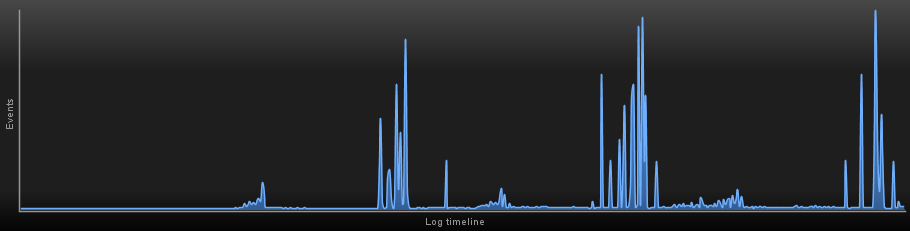

This is the distribution of the events, the peaks we can observe are mainly from October to December of each year.

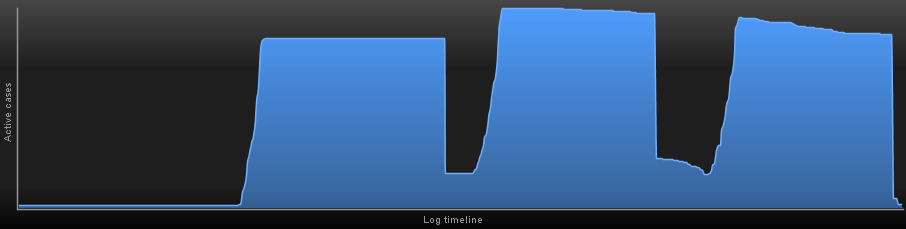

This is the active cases graph, most of the cases start around May/June and end in December, but as we can see there are some residual events every year.

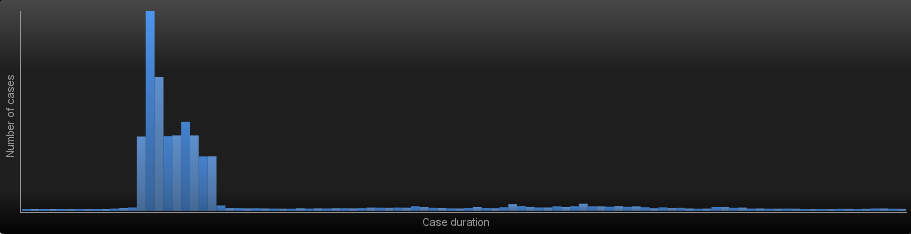

Most of the cases require less than a year in total. The mean case duration is 43 weeks.
These are the total event log statistics:

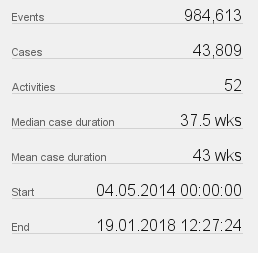

Before filtering the log to obtain an easier to grasp process map it could be useful to have at least an overview of the whole process.

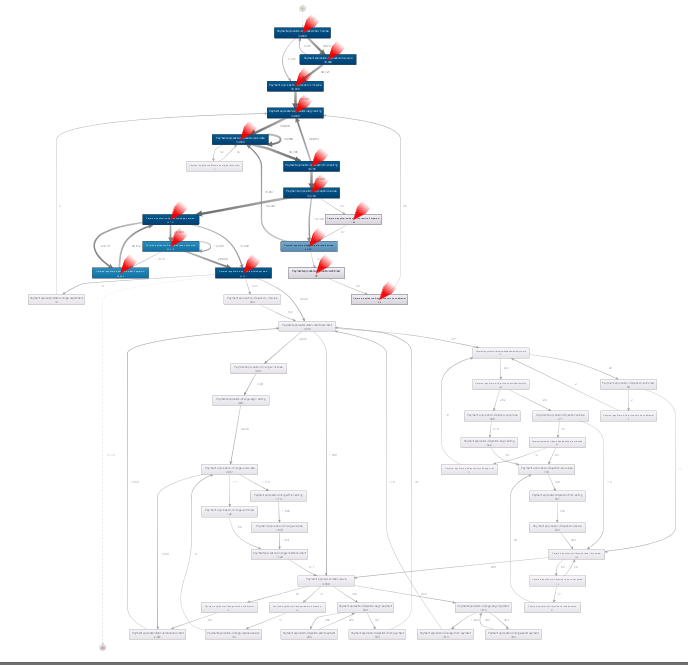

The red arrows point to the Payment application-application part of the map, that is the most frequent activities.
This is supported by setting the color schema to represent *Case frequency*, we can clearly see that all the darker coloured ones are part of this group (The darker the color the more frequent the activity)

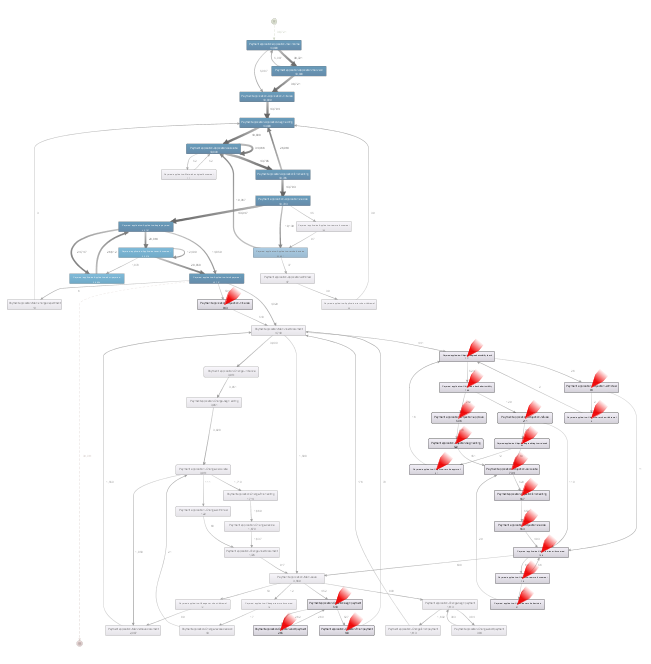

These are the activities regarding *Objections*, they are useful in the understanding of Undesidered outcome 2.

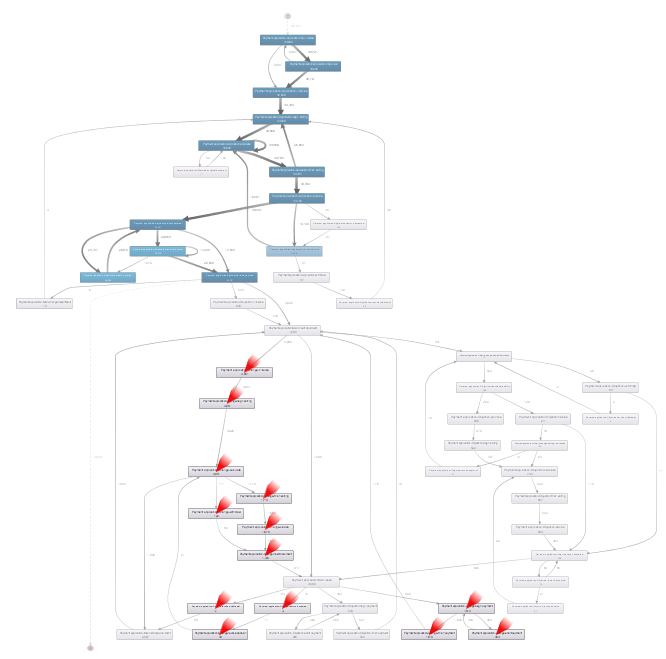

These are the activities relative to the *Change* subprocess that are also useful in the study of Undesidered outcome 2. 
The remaining cells are relative to *Main* subprocess.

Now we can proceed with filtering, so let's recap what we absolutely need in our process map:
- Begin payment, for the study of undesidered outcome 1
- Abort payment, for the study of undesidered outcome 1
- Subprocess Change, for the study of undesidered outcome 2
- Subprocess Objection, for the study of undesidered outcome 2

Mantaining 100% of cases and filtering activities we don't need this seems like a good compromise of a process map for understanding.

![map](../img/pa_2.png)

Below every path frequency are included also the average duration of the activity to the next. The most notable is that from begin Payment to Change initialize there is an average long transition time.

## Tackling the problem

The first thing we need to do is to engineer the dataset of the payment applications to find out the labels of our undesidered outcomes.

In [7]:
df = pd.read_csv('../data/Payment application.csv')

Now that we loaded the data we can take a peek to think what we can do next

In [8]:
df.head()

,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,(case) amount_applied0,(case) amount_applied1,(case) amount_applied2,(case) amount_applied3,...,(case) young farmer,activity,concept:name,docid,doctype,eventid,lifecycle:transition,note,subprocess,success
0,-18008611495569447,Payment application-Application-mail income,0;n/a,2015/05/08 00:00:00.000,Variant 8,8,960.35,NaN,NaN,NaN,...,False,mail income,mail income,-18008611495569447,Payment application,NaN,complete,none,Application,True
1,-18008611495569447,Payment application-Application-mail valid,0;n/a,2015/05/08 00:00:00.000,Variant 8,8,960.35,NaN,NaN,NaN,...,False,mail valid,mail valid,-18008611495569447,Payment application,NaN,complete,none,Application,True
2,-18008611495569447,Payment application-Application-initialize,Document processing automaton,2015/11/06 11:21:27.376,Variant 8,8,960.35,NaN,NaN,NaN,...,False,initialize,initialize,-18008611495569447,Payment application,-1.800861e+16,complete,none,Application,True
3,-18008611495569447,Payment application-Application-begin editing,727350,2015/11/10 17:17:50.045,Variant 8,8,960.35,NaN,NaN,NaN,...,False,begin editing,begin editing,-18008611495569447,Payment application,-1.080806e+17,complete,automatic,Application,True
4,-18008611495569447,Payment application-Application-calculate,727350,2015/11/10 17:17:57.085,Variant 8,8,960.35,NaN,NaN,NaN,...,False,calculate,calculate,-18008611495569447,Payment application,-1.080806e+17,complete,automatic,Application,True


To find out our undesidered outcomes 1 we just need 3 activities for each case: Application initialize, Begin payment and abort payment.
A payment is late basically if the last activity is not a begin payment (So an abort or just initialized) or it is a begin payment but from a different year than the case year

1. There is no ‘begin payment’ event in the case.2. The last ‘begin payment’ event is followed by an ‘abort payment’ event.3. The last ‘begin payment’ event occurs in a later year than what the case wasstarted in.

In [9]:
uo1_code = """
activities = ['Payment application-Application-initialize', 'Payment application-Application-begin payment', 'Payment application-Application-abort payment']

df_prepared = df[df['Activity'].isin(activities)]

cases = df_prepared['Case ID'].unique()

uo1_list = []

for case in cases:
    is_late = False
    
    case_df = df_prepared[df_prepared['Case ID'] == case]
    last_activity = case_df.tail(1)
    
    if last_activity['Activity'].item() != 'Payment application-Application-begin payment':
        # Last activity is initialize or abort payment
        is_late = True
    else:
        payment_dt = datetime.strptime(last_activity['Complete Timestamp'].item(), '%Y/%m/%d %H:%M:%S.%f')
        case_year = last_activity['(case) year']
        if payment_dt.year > case_year.item():
            is_late = True
        
    uo1_list.append((case, is_late))
    
uo1_df = pd.DataFrame(uo1_list, columns=['Case ID', 'Late Payment'])

uo1_df.to_csv('../data/uo1.csv', index=False)
"""

In [12]:
uo1_df = pd.read_csv('../data/uo1.csv')